# Solving in Python with LeNet

In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface.

### 1. Setup

* Set up the Python environment: we'll use the `pylab` import for numpy and plot inline.

In [2]:
from pylab import *
%matplotlib inline

* Import `caffe`, adding it to `sys.path` if needed. Make sure you've built pycaffe.

In [3]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

* We'll be using the provided LeNet example data and networks (make sure you've downloaded the data and created the databases, as below).

In [4]:
# run scripts from caffe root
import os
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
I0808 22:59:29.963397 2007105536 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0808 22:59:29.964355 2007105536 convert_mnist_data.cpp:88] A total of 60000 items.
I0808 22:59:29.964373 2007105536 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0808 22:59:30.376353 2007105536 convert_mnist_data.cpp:108] Processed 60000 files.
I0808 22:59:30.406060 2007105536 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0808 22:59:30.407958 2007105536 convert_mnist_data.cpp:88] A total of 10000 items.
I0808 22:59:30.407994 2007105536 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0808 22:59:30.497622 2007105536 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


### 2. Creating the net 

Now let's make a variant of LeNet, the classic 1989 convnet architecture.

We'll need two external files to help out:
* the net `prototxt`, defining the architecture and pointing to the train/test data
* the solver `prototxt`, defining the learning parameters

We start by creating the net. We'll write the net in a succinct and natural way as Python code that serializes to Caffe's protobuf model format.

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

In [5]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

The net has been written to disk in a more verbose but human-readable serialization format using Google's protobuf library. You can read, write, and modify this description directly. Let's take a look at the train net.

In [6]:
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

Now let's see the learning parameters, which are also written as a `prototxt` file (already provided on disk). We're using SGD with momentum, weight decay, and a specific learning rate schedule.

In [7]:
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


### 3. Loading and checking the solver

* Let's pick a device and load the solver. We'll use SGD (with momentum), but other methods (such as Adagrad and Nesterov's accelerated gradient) are also available.

In [8]:
caffe.set_device(0)
caffe.set_mode_gpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

* To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [9]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [10]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

* Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [11]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.3857996463775635, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


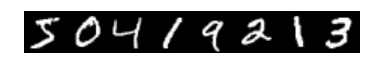

In [12]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


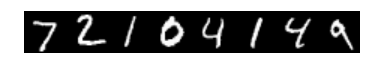

In [13]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

### 4. Stepping the solver

Both train and test nets seem to be loading data, and to have correct labels.

* Let's take one step of (minibatch) SGD and see what happens.

In [14]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

(-0.5, 24.5, 19.5, -0.5)

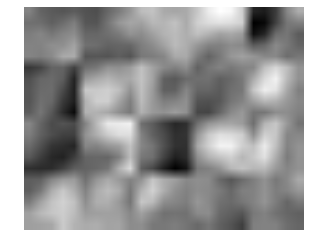

In [15]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

### 5. Writing a custom training loop

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [16]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 8.81 s, sys: 444 ms, total: 9.25 s
Wall time: 8.17 s


* Let's plot the train loss and test accuracy.

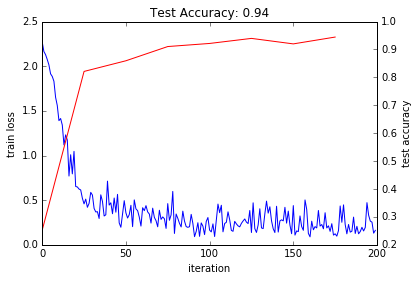

In [17]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

The loss seems to have dropped quickly and coverged (except for stochasticity), while the accuracy rose correspondingly. Hooray!

* Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

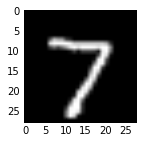

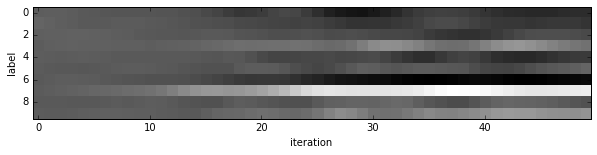

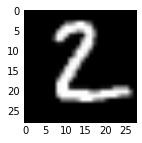

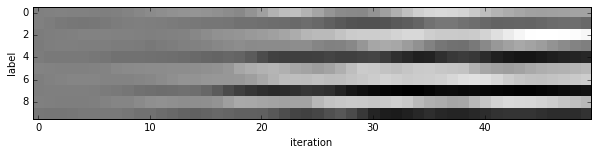

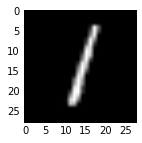

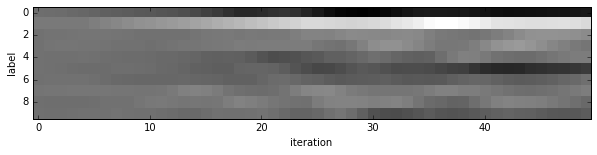

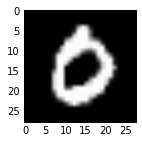

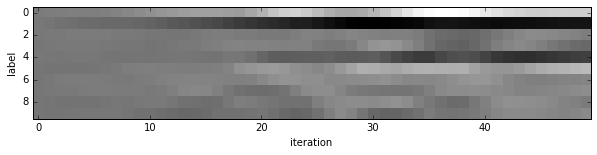

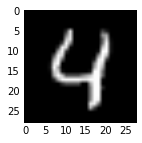

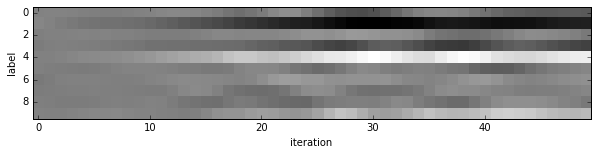

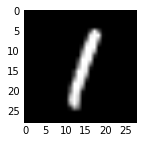

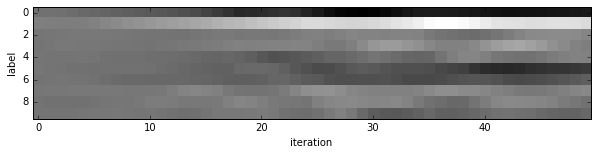

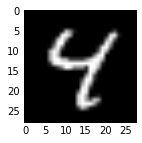

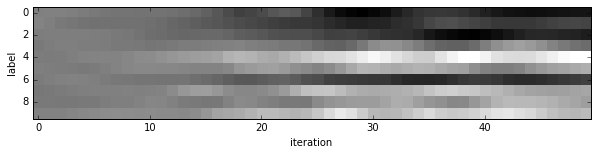

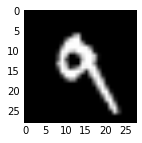

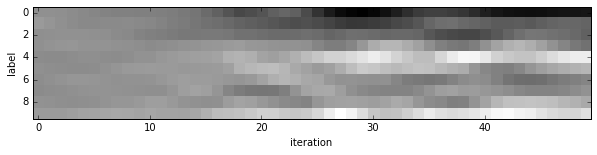

In [18]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

We started with little idea about any of these digits, and ended up with correct classifications for each. If you've been following along, you'll see the last digit is the most difficult, a slanted "9" that's (understandably) most confused with "4".

* Note that these are the "raw" output scores rather than the softmax-computed probability vectors. The latter, shown below, make it easier to see the confidence of our net (but harder to see the scores for less likely digits).

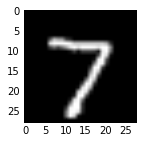

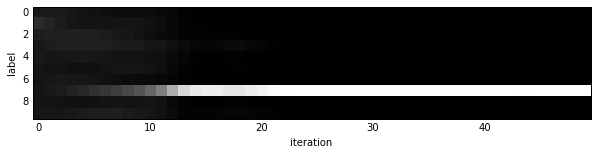

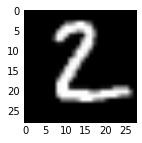

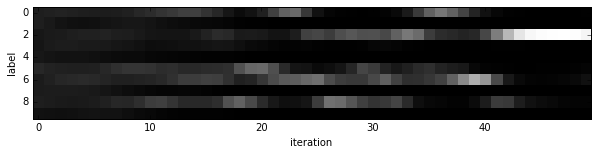

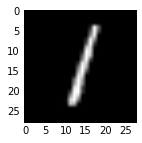

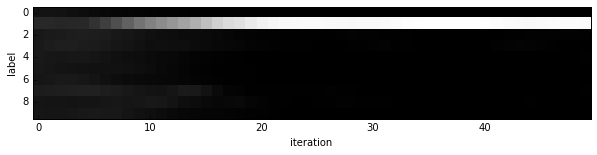

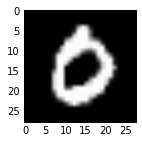

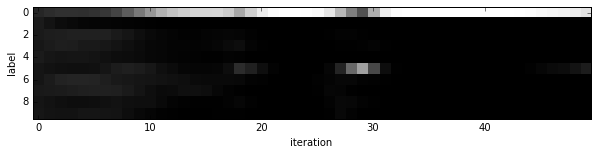

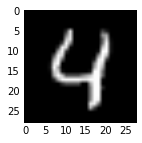

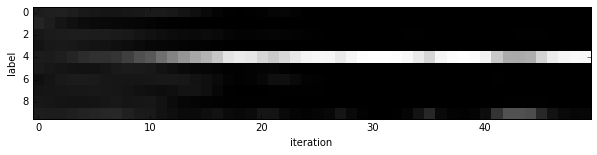

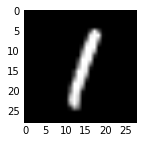

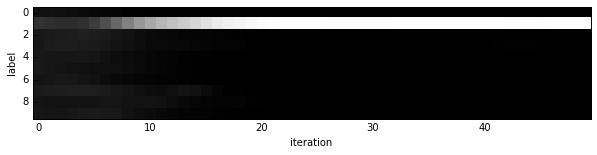

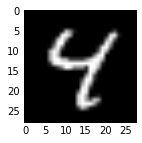

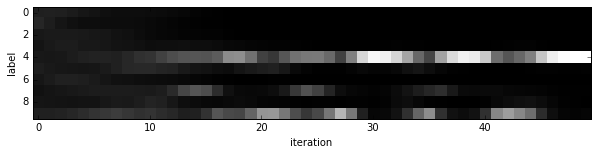

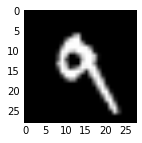

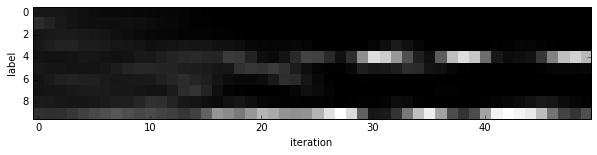

In [19]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

### 6. Experiment with architecture and optimization

Now that we've defined, trained, and tested LeNet there are many possible next steps:

- Define new architectures for comparison
- Tune optimization by setting `base_lr` and the like or simply training longer
- Switching the solver type from `SGD` to an adaptive method like `AdaDelta` or `Adam`

Feel free to explore these directions by editing the all-in-one example that follows.
Look for "`EDIT HERE`" comments for suggested choice points.

By default this defines a simple linear classifier as a baseline.

In case your coffee hasn't kicked in and you'd like inspiration, try out

1. Switch the nonlinearity from `ReLU` to `ELU` or a saturing nonlinearity like `Sigmoid`
2. Stack more fully connected and nonlinear layers
3. Search over learning rate 10x at a time (trying `0.1` and `0.001`)
4. Switch the solver type to `Adam` (this adaptive solver type should be less sensitive to hyperparameters, but no guarantees...)
5. Solve for longer by setting `niter` higher (to 500 or 1,000 for instance) to better show training differences

In [ ]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

### define net
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()
    
    # keep this data layer for all networks
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    # EDIT HERE to try different networks
    # this single layer defines a simple linear classifier
    # (in particular this defines a multiway logistic regression)
    #n.score =  L.InnerProduct(n.data, num_output=10, weight_filler=dict(type='xavier'))
    
    # EDIT HERE this is the LeNet variant we have already tried
    n.conv1 = L.Convolution(n.data, kernel_size=3, pad=1, stride=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu1 = L.ReLU(n.pool1, in_place=True)
    n.bn1   = L.BatchNorm(n.pool1, in_place=True)
    
    n.conv2 = L.Convolution(n.pool1, kernel_size=3, pad=1, stride=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    # n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    # n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    # EDIT HERE consider L.ELU or L.Sigmoid for the nonlinearity
    # n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score =   L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='xavier'))
    
    # keep this loss layer for all networks
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_test_lmdb', 100)))

### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "SGD"

# Set the initial learning rate for SGD.
s.base_lr = 0.01  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 5e-4

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 1000

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = 250  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
Iteration 200 testing...
Iteration 225 testing...
